# 1. Problem presentation 

This notebook illustrates in a simple way that for a dynamical system very sparsely observed, using an advanced data assimilation method (here, an Ensemble Kalman filter, EnKF) rather than a crude one (here, direct substitution of the observed variable with the observation) is essential to estimate the system.

The illustration uses the 3-variable, chaotic Lorenz 63 system (https://en.wikipedia.org/wiki/Lorenz_system). This dynamical model is often used to test data assimilation methods, because it displays a chaotic behavior, as the atmosphere and the ocean do, with very low dimensionality.

We consider the Lorenz equations :

\begin{equation} 
\begin{aligned} \frac{dx}{dt} & = \sigma(y-x) \\ \frac{dy}{dt} & = \rho x - y - xz \\ \frac{dz}{dt} & = -\beta z + xy \end{aligned} 
\end{equation} 

This system is a non-linear differential system of order 1. Using the following parameters, $\sigma=10$, $\beta=\frac{8}{3}$, $\rho=28.0$, it gives rise to a chaotic system. the solution is seen to orbit around two equilibrium points giving two 'regimes'.

In the sequel we will denote the model variable $u = (x, y, z)$, and $u_0 = (x_0,y_0,z_0)$ the initial condition.

The main steps covered below are:
- Simulation and plots of the Lorenz model
- Test model's sensitivity to changes in initial condition and a model parameter
- Experiment assimilation of observation drawn from the reference trajectory into the model with changed initial condition and parameter: direct substitution, and Ensemble Kalman filtering


In [1]:
%matplotlib nbagg
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML
import numpy as np
from scipy import integrate

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.colors import cnames
import matplotlib.animation as animation

## 1.1 Simulation and plots

Let us start by defining a pyhon function that calculates and draws the trajectory of a particule whose position is defined by the Lorenz equation. This function takes as input the parameters of the Lorenz system ($\sigma$, $\beta$, $\rho$), the initialisation (x0, y0, z0) the temporal window  (max_time) and the visualisation angle (angle).


In [2]:
def solve_lorenz(max_time=4.0, sigma=10.0, beta=8./3, rho=28.0, x0=10., y0=20.,z0=10.5):

    deltat = 1/100.
    res = int(max_time / deltat)
    
    x = np.zeros((res+1))
    y = np.zeros((res+1))
    z = np.zeros((res+1))
      
    x[0]= x0
    y[0]=y0
    z[0]=z0
    for t in range(0,res):
        x[t+1] = x[t]+deltat*sigma*(y[t]-x[t]) 
        y[t+1] = y[t]+deltat*(rho*x[t]-y[t]-x[t]*z[t]) 
        z[t+1] = z[t]+deltat*(-beta*z[t]+x[t]*y[t]) 

    return x, y, z
    
    
def draw_lorenz(angle=0.0, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0,  x0=10., y0=20.,z0=10.5):
    
    
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    # ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    ax.set_title('Lorenz attractor')

    x, y, z = solve_lorenz(max_time=max_time, sigma=sigma, beta=beta, rho=rho,  x0=x0, y0=y0,z0=z0)
    lines = ax.plot(x, y, z, '-')
    plt.setp(lines, linewidth=2)
    
    ax.view_init(30, angle)
    plt.show()

    f, axarr = plt.subplots(3, sharex=True)
    axarr[0].plot(x, label='x')
    axarr[0].legend(loc="upper right")
    axarr[1].plot(y, label='y')
    axarr[1].legend()
    axarr[2].plot(z, label='z')
    axarr[2].legend()
    
    return 

<IPython.core.display.Javascript object>


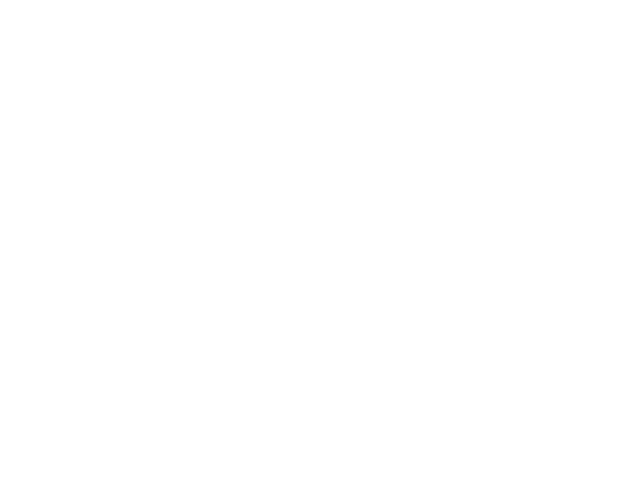

<IPython.core.display.Javascript object>


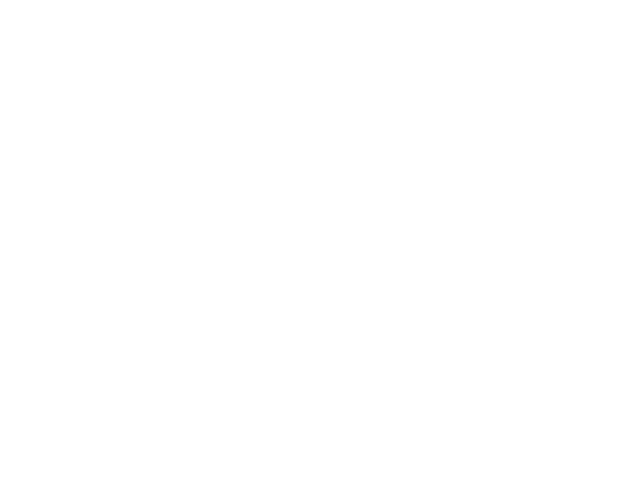

In [3]:
draw_lorenz(angle=-20.0, max_time=10.)

## 1.2 Animation

In [4]:
def stack_lorenz(solve,max_time=4.0, sigma=10.0, beta=8./3, rho=28.0, x0=10., y0=20.,z0=10.5):
    x, y, z = solve(max_time=max_time,sigma=sigma, beta=beta,rho=rho,x0=x0, y0=y0,z0=z0)
    
    res = int(100 * max_time)

    data=np.empty((3,res+1))
    data[0,:]=x[:]
    data[1,:]=y[:]
    data[2,:]=z[:]
    return data

def update_lines(num, dataLines, lines):
    for line, data in zip(lines, dataLines):
        line.set_data(data[0:2, :num])
        line.set_3d_properties(data[2, :num])
    return lines

<IPython.core.display.Javascript object>


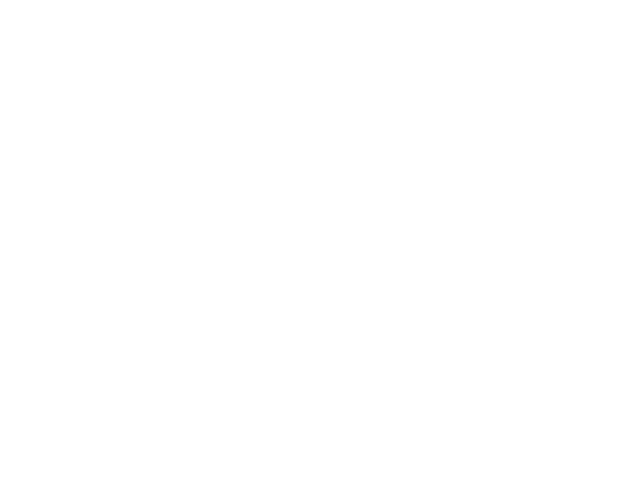

In [5]:

max_time = 10.0

fig = plt.figure()
ax  = p3.Axes3D(fig)

ax.set_xlim3d((-25., 25.))
ax.set_ylim3d((-35., 35.))
ax.set_zlim3d((5., 55.))

data = [stack_lorenz(solve_lorenz,max_time=max_time)]

lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1])[0] for dat in data]

line_ani = animation.FuncAnimation(fig, update_lines, 1001, fargs=(data, lines),
                                   interval=50, blit=False)

--------------------------------------------------------------------------------------------------

# 2. Reference simulation and perturbation

Use the following lines to study the sensibility of the solution to inaccurate initial condition and/or inaccurate parameters


## 2.1 Lorenz model with inaccurate initial condition

In [6]:
def draw_lorenz_comparison(angle=-20.0, max_time=10.0, sigma_ref=10.0, beta_ref=8./3, rho_ref=28.0,  
                           x0_ref=10., y0_ref=20.,z0_ref=10.5,
                           sigma_inac=10.0, beta_inac=8./3, rho_inac=28.0,  
                           x0_inac=10., y0_inac=20.,z0_inac=10.5):
    
    
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    # ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-25, 25))
    ax.set_ylim((-35, 35))
    ax.set_zlim((5, 55))
    ax.set_title('Lorenz attractor')

    x_ref, y_ref, z_ref = solve_lorenz(max_time=max_time, sigma=sigma_ref, beta=beta_ref, rho=rho_ref,
                                x0=x0_ref, y0=y0_ref,z0=z0_ref)
    x_inac,y_inac,z_inac = solve_lorenz(max_time=max_time, sigma=sigma_inac, beta=beta_inac, rho=rho_inac,
                                x0=x0_inac, y0=y0_inac,z0=z0_inac)
    lines_ref = ax.plot(x_ref, y_ref, z_ref, '-')
    lines_inac = ax.plot(x_inac, y_inac, z_inac, '-')
    plt.setp(lines_ref, linewidth=2,label='reference')
    plt.setp(lines_inac, linewidth=2,label='inacurrate')
    ax.view_init(30, angle)
    plt.show()
    plt.legend()

    f, axarr = plt.subplots(3, sharex=True)
    axarr[0].plot(x_ref, label='x reference')
    axarr[0].plot(x_inac, label='x inacurrate')
    axarr[0].legend(loc="upper right")
    axarr[1].plot(y_ref, label='y reference')
    axarr[1].plot(y_inac, label='y inacurrate')
    axarr[1].legend(loc="upper right")
    axarr[2].plot(z_ref, label='z reference')
    axarr[2].plot(z_inac, label='z inacurrate')
    axarr[2].legend(loc="upper right")
    
    return 

<IPython.core.display.Javascript object>


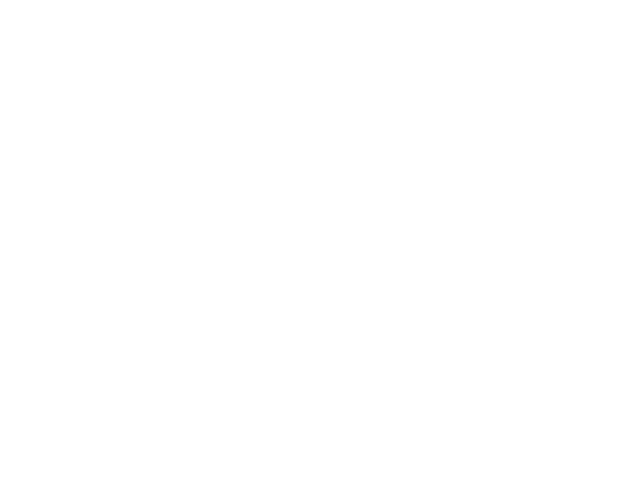

<IPython.core.display.Javascript object>


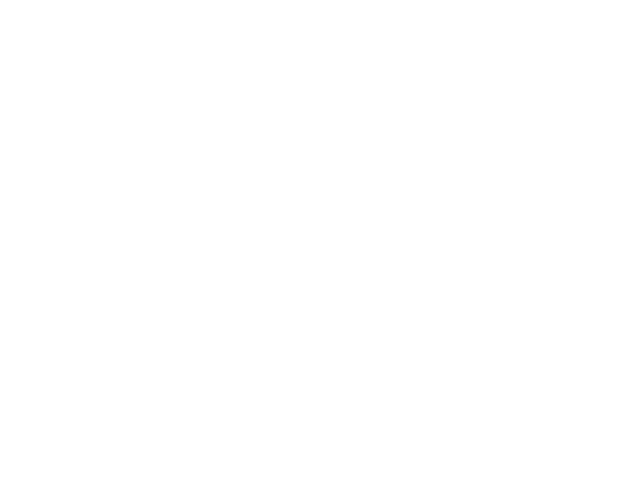

In [7]:
draw_lorenz_comparison(x0_inac=11., y0_inac=21.,z0_inac=12.5)



## 2.2 Lorenz model with inaccurate parameters


<IPython.core.display.Javascript object>


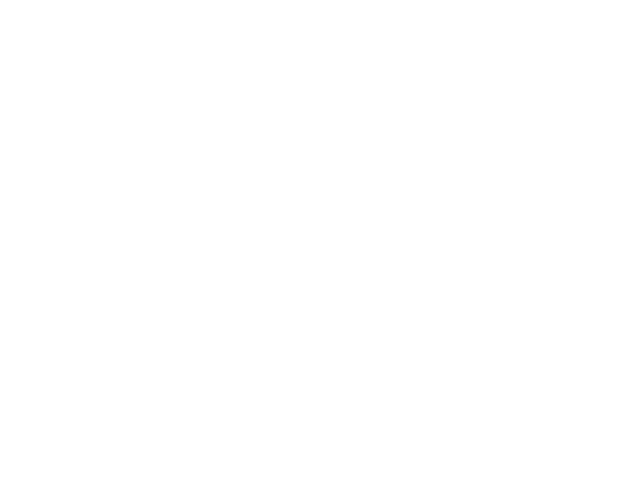

<IPython.core.display.Javascript object>


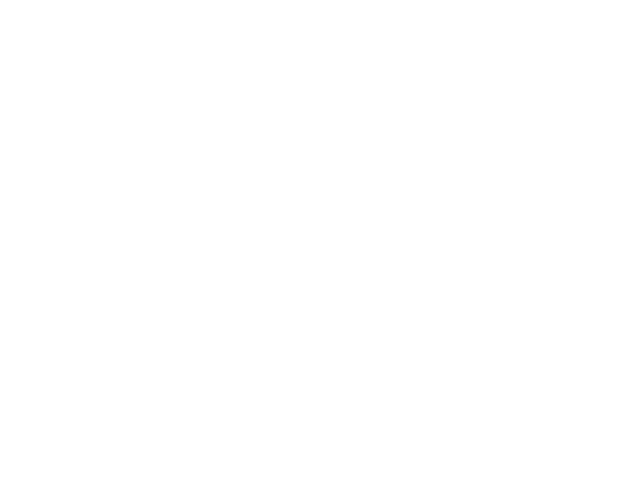

In [8]:
draw_lorenz_comparison(sigma_inac=10.0, beta_inac=8./3, rho_inac=29.0)

## 2.3 Lorenz model with inacurrate conditions and inacurrate parameters

<IPython.core.display.Javascript object>


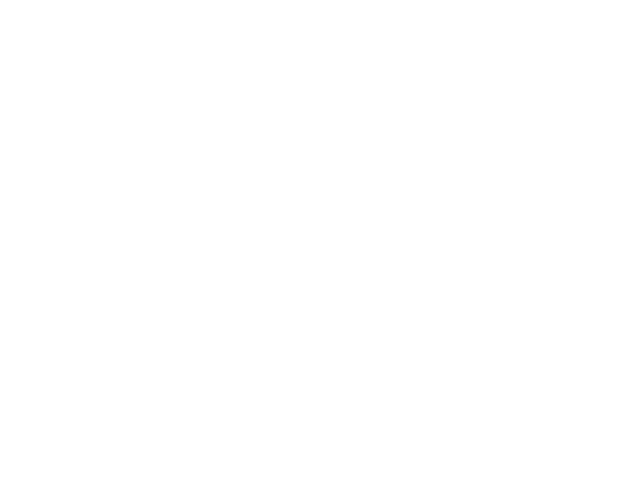

<IPython.core.display.Javascript object>


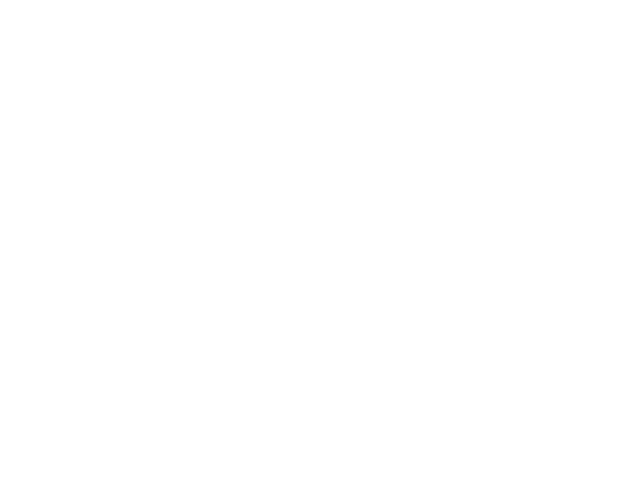

In [9]:
draw_lorenz_comparison(sigma_inac=10.0, beta_inac=8./3, rho_inac=29.0, x0_inac=11., y0_inac=21.,z0_inac=12.5)

---------------------------------------------------------------------------------------

# 3. Data assimilation

We now turn to data assimilation. To do so, we will perform twin experiments.
We assume our model is inaccurate, and the initial condition is not perfectly known. To mimic this, we assimilate observations extracted from the reference simulation ($\rho=28$, initial condition = (1.5, -1.5, 21) ) into an unperfect model ($\rho=29$) initialized with unperfect conditions : the background is set to (3, -3, 21).

We first consider the case where ALL variables (x, but also y and z) are observed at all times.

In [10]:
# Observation extracted from reference simulation
x_obs, y_obs, z_obs = solve_lorenz(x0=1.5, y0=-1.5,z0=21)

# We suppose an inaccurate system:
# Background(initialized unperfect condition)
x_b = 3
y_b = -3
z_b = 21

#unperfected model
sigma_un = 10
beta_un = 8/3.0
rho_un = 29.0

# If we trust the observtions and all variables are observed,
# in one step we go the the real solution

## 3.1 First data assimilation experiment: Extended Kalman filter
Implement the Extended Kalman filter algorithm, and validate it in the twin experiments framework: initialise the algorithm with the background, use the observations, and check that your analysis $u_a$ is a good approximation of the exact solution $u_{ref}$. Provide figures to illustrate this point (at least one figure showing the evolution of the reference, the background and the analysis trajectories during the time window [0, 4]).

In [41]:
def Model(u, sigma, beta, rho, dt):
    u1 = (sigma*(u[1]-u[0]))*dt
    u2 = (rho*u[0]-u[1]-u[0]*u[2])*dt
    u3 = (-beta*u[2]+u[0]*u[1])*dt
    u = u+ np.matrix([[u1.item(0)], [u2.item(0)], [u3.item(0)]])
    return u

def Ext_kalman_forecast(u, P, Q, M, sigma, beta, rho, dt):
    u = Model(u, sigma, beta, rho, dt)
    P = M*P*M.T + Q
    return u, P

def Ext_kalman_analysis(u, P, y, R, H):
    dim = u.shape[0]
    if np.linalg.norm(R)==0:                    # Perfect Observations
        K=np.linalg.inv(H)
    else:
        K = P*H.T*np.linalg.inv(R + H*P*H.T)    # Kalman Gain
    P = (np.matrix(np.eye(dim)) - K*H)*P        # Error Covariance Matrix
    innovation = y - H*u
    u = u+ K*innovation                         # state vector
    return u, P

def kalman_2steps(u, P, y, R, Q, M, H, sigma, beta, rho, dt):
    u,P = Ext_kalman_forecast(u, P, Q, M, sigma, beta, rho, dt)
    u,P = Ext_kalman_analysis(u, P, y, R, H)
    return u,P

In [42]:
# initialisation
background =np.matrix([[x_b],[y_b],[z_b]])    # initial value, starting point
u=background
variance=2

t=4
dt = 1/100.
times = np.arange(0,t,dt)
res = times.shape[0]

P=np.eye(3)                                   # covariance matrix
Q=variance*np.ones((3,3))                     # model error covariance

# All variable are observed
H=np.eye(3)                                   # observation operator
R=np.matrix([[0]])                            # observation error covariance matrix (perfect Obs)

x_un = np.zeros((res+1))                      # where I save solution
y_un = np.zeros((res+1))                      # where I save solution
z_un = np.zeros((res+1))                      # where I save solution
x_un[0]=u[0]
y_un[0]=u[1]
z_un[0]=u[2]

# steps of Extended Kalman filter
for k in range(0,res):
    M = np.matrix([[1-sigma_un*dt, (rho_un-u[2])*dt, u[1]*dt],
       [sigma_un*dt, 1-dt, -u[0]*dt],
       [ 0, -u[1]*dt, 1-beta_un*dt]])
    y=[x_obs[k]], [y_obs[k]], [z_obs[k]]
    u, P = kalman_2steps(u, P, y, R, Q, M, H, sigma_un, beta_un, rho_un, dt) 
    x_un[k+1]=u[0]
    y_un[k+1]=u[1]
    z_un[k+1]=u[2]

<IPython.core.display.Javascript object>


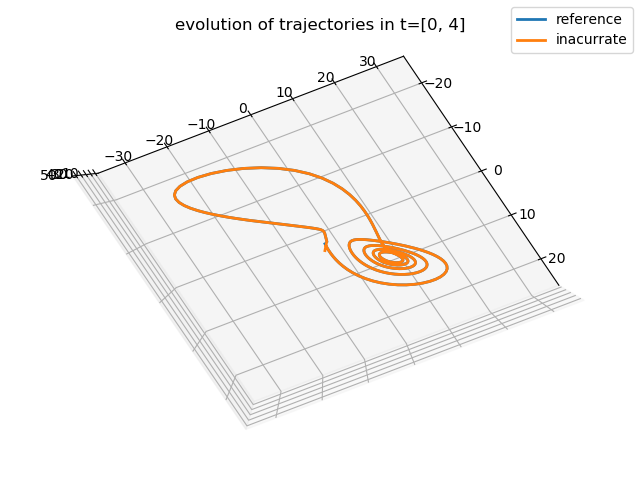

<IPython.core.display.Javascript object>


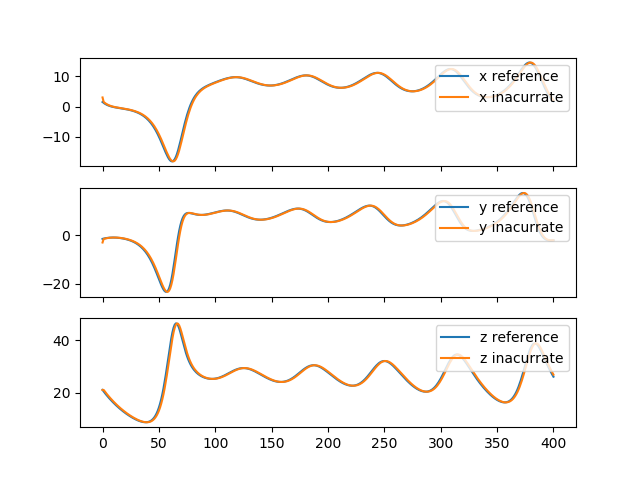

In [43]:
angle= -20
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# ax.axis('off')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('evolution of trajectories in t=[0, 4]')

lines_ref = ax.plot(x_obs, y_obs, z_obs, '-')
lines_inac = ax.plot(x_un, y_un, z_un, '-')
plt.setp(lines_ref, linewidth=2,label='reference')
plt.setp(lines_inac, linewidth=2,label='inacurrate')
ax.view_init(30, angle)
plt.show()
plt.legend()

f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x_obs, label='x reference')
axarr[0].plot(x_un, label='x inacurrate')
axarr[0].legend(loc="upper right")
axarr[1].plot(y_obs, label='y reference')
axarr[1].plot(y_un, label='y inacurrate')
axarr[1].legend(loc="upper right")
axarr[2].plot(z_obs, label='z reference')
axarr[2].plot(z_un, label='z inacurrate')
axarr[2].legend(loc="upper right")

## 3.2 Second data assimilation experiment: Ensemble Kalman filter
We perform the same experiment as above, same model, same observations, but with an Ensemble Kalman filter (EnKF). The EnKF is a Monte Carlo method, therefore requires the definition of an ensemble (sample) size. An estimation of the observation error variance is also needed.

In [14]:
def Model(u, sigma, beta, rho, dt):
    u1 = (sigma*(u[0,1]-u[0,0]))*dt
    u2 = (rho*u[0,0]-u[0,1]-u[0,0]*u[0,2])*dt
    u3 = (-beta*u[0,2]+u[0,0]*u[0,1])*dt
    u = u + np.matrix([u1, u2, u3])
    return u

def Ensemble_Kalman_initialization(u, P, size):
    U=np.asmatrix(np.zeros((size,u.shape[1])))
    for i in range (size):
        U[i,:] = u + np.random.randn(1, u.shape[1])
    return U
        
def Ensemble_kalman_forecast(U, P, Q, M, sigma, beta, rho, dt, size):
    for i in range (size):
        U[i,:] = Model(U[i,:], sigma, beta, rho, dt)
    Ubar = sum(U)/size
    P = np.zeros((u.shape[1],u.shape[1]))
    for i in range (size):
        P += np.outer(U[i,:]-Ubar,U[i,:]-Ubar)
    P = P/(size-1)
    return U, Ubar, P

def Ensemble_kalman_analysis(U, Ubar, P, y, R, H, size):
    dim = u.shape[1]
    PHT = np.zeros((dim,dim))
    HPHT = np.zeros((dim,dim))
    for i in range (size):
        PHT += np.outer(U[i,:]-Ubar,H*U[i,:].T-H*Ubar.T)
        HPHT += np.outer(H*U[i,:].T-H*Ubar.T,H*U[i,:].T-H*Ubar.T)
    PHT= PHT/(size-1)
    HPHT= HPHT/(size-1)
    if np.linalg.norm (HPHT + R,2) > 0.0001:
        K = PHT*np.linalg.inv(R + HPHT)              # Kalman Gain
    else:
        K=np.linalg.inv(H)
    for i in range (size):
        U[i,:] = U[i,:] + (K*(y-H*U[i,:].T)).T       # state vector
    return U

def Enskalman_2steps(U, P, y, R, Q, M, H, sigma, beta, rho, dt,size):
    U,Ubar,P = Ensemble_kalman_forecast(U, P, Q, M, sigma, beta, rho, dt, size)
    U = Ensemble_kalman_analysis(U, Ubar, P, y, R, H, size)
    return U

In [15]:
# initialisation
size = 20
u=np.matrix([x_b,y_b,z_b]) 

X_un = np.zeros((size,res+1))                      # where I save solution
Y_un = np.zeros((size,res+1))                      # where I save solution
Z_un = np.zeros((size,res+1))                      # where I save solution

# estimation of observation error variance R
R=np.matrix([[0]])

# steps of Ensemble Kalman Filter
U = Ensemble_Kalman_initialization(u, P, size)
X_un[:,0]=np.asarray( U[:,0]).reshape(-1)
Y_un[:,0]=np.asarray( U[:,1]).reshape(-1)
Z_un[:,0]=np.asarray( U[:,2]).reshape(-1)
for k in range(0,res):
    M = np.matrix([[1-sigma_un*dt, (rho_un-u[0,2])*dt, u[0,1]*dt],
       [sigma_un*dt, 1-dt, -u[0,0]*dt],
       [ 0, -u[0,1]*dt, 1-beta_un*dt]])
    y= [x_obs[k]], [y_obs[k]], [z_obs[k]]
    U = Enskalman_2steps(U, P, y, R, Q, M, H, sigma_un, beta_un, rho_un, dt, size)
    X_un[:,k+1]=np.asarray( U[:,0]).reshape(-1)
    Y_un[:,k+1]=np.asarray( U[:,1]).reshape(-1)
    Z_un[:,k+1]=np.asarray( U[:,2]).reshape(-1)


<IPython.core.display.Javascript object>


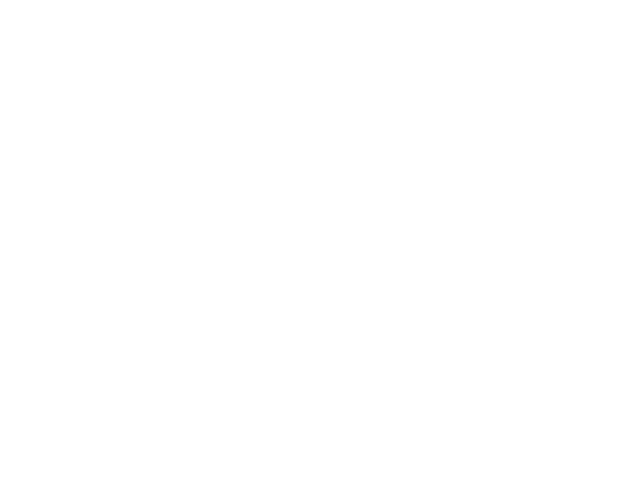

<IPython.core.display.Javascript object>


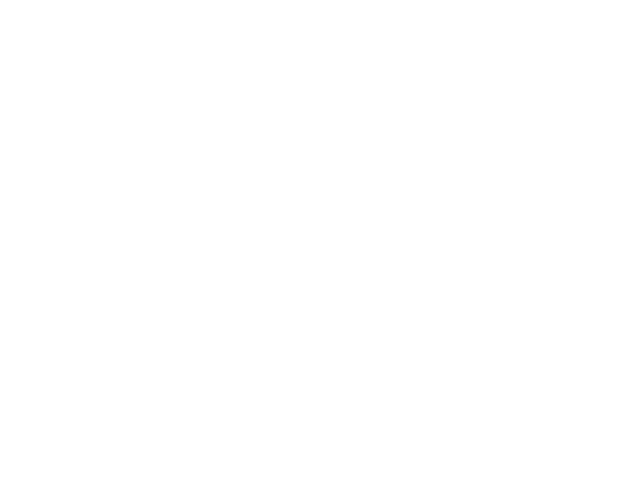

In [16]:
angle= -20
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# ax.axis('off')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('evolution of trajectories in t=[0, 4]')

x_ens=sum(X_un)/size
y_ens=sum(Y_un)/size
z_ens=sum(Z_un)/size

lines_ref = ax.plot(x_obs, y_obs, z_obs, '-')
lines_inac = ax.plot(x_ens, y_ens, z_ens, '-')
plt.setp(lines_ref, linewidth=2,label='reference')
plt.setp(lines_inac, linewidth=2,label='inacurrate')
ax.view_init(30, angle)
plt.show()
plt.legend()

f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x_obs, label='x reference')
axarr[0].plot(x_ens, label='x inacurrate')
axarr[0].legend(loc="upper right")
axarr[1].plot(y_obs, label='y reference')
axarr[1].plot(y_ens, label='y inacurrate')
axarr[1].legend(loc="upper right")
axarr[2].plot(z_obs, label='z reference')
axarr[2].plot(z_ens, label='z inacurrate')
axarr[2].legend(loc="upper right")

## 3.3 Third data assimilation experiment: Variational approaches
Similarly, implement a variational algorithm for the same twin experiments framework. To avoid adjoint coding, consider using a gradient-free minimisation algorithm, such as simulated annealing (see Wikipedia). Feel free to use built-in functions for that (scipy.optimize.anneal in Python).
Similarly provide at least one figure showing reference, background and analysis trajectories over time. Provide also a figure showing the deacrease of the cost function with the iteration number.

In [59]:
from scipy import optimize
np.random.seed(555)   # Seeded to allow replication.

def Model(u, sigma, beta, rho, dt):
    u1 = (sigma*(u[1]-u[0]))*dt
    u2 = (rho*u[0]-u[1]-u[0]*u[2])*dt
    u3 = (-beta*u[2]+u[0]*u[1])*dt
    u = u+ [u1, u2, u3]
    return u

In [60]:
# initialisation
u_b = np.array([x_b,y_b,z_b])
P = np.eye(3)
R = np.eye(3)
H = np.eye(3)

P_inv = np.linalg.inv(P)
R_inv = np.linalg.inv(R)
H_inv = np.linalg.inv(H)

X_un = np.zeros((1,res+1))                      # where I save solution
Y_un = np.zeros((1,res+1))                      # where I save solution
Z_un = np.zeros((1,res+1))                      # where I save solution

u = [None] * res
d = [None] * res
y = [None] * res

u[0] = u_b

for k in range(1,res):
    u[k] = Model(u[k-1], sigma_un, beta_un, rho_un, dt)
    
for k in range(res):
    y[k] = np.array([x_obs[k], y_obs[k], z_obs[k]])
    d[k] = y[k] - H_inv.dot(u[k])

def f(v):
    j_b = (v-u_b).T.dot(P_inv.dot((v-u_b)))
    j_o = 0
    for k in range(res):
        j_o = j_o + d[k].T.dot(R_inv.dot(d[k]))
    j_m = 0 # In first appoximation, we suppose that the model is perfect.
    j=j_b+j_o+j_m
    return j

# Simulated Annealing
u_0 = [1, 1, 1] # Initial guess
ret = optimize.basinhopping(f, u_0, niter=200)
print("global minimum: x = [%.10f, %.2f, %.2f], f(x0) = %.2f" % (ret.x[0],ret.x[1],ret.x[2], ret.fun))
print(u_b)


global minimum: x = [3.0000006475, -3.00, 21.00], f(x0) = 62794.07
[ 3 -3 21]


In [61]:
u = [None] * res
u[0] = u_b
Model(u_b, sigma_un, beta_un, rho_un, dt)

array([ 2.4 , -2.73, 20.35])

In [62]:
# Model with the new estimated initial value
u = [None] * res
u[0] = u_b

for k in range(1,res):
    u[k] = Model(u[k-1], sigma_un, beta_un, rho_un, dt)

<IPython.core.display.Javascript object>


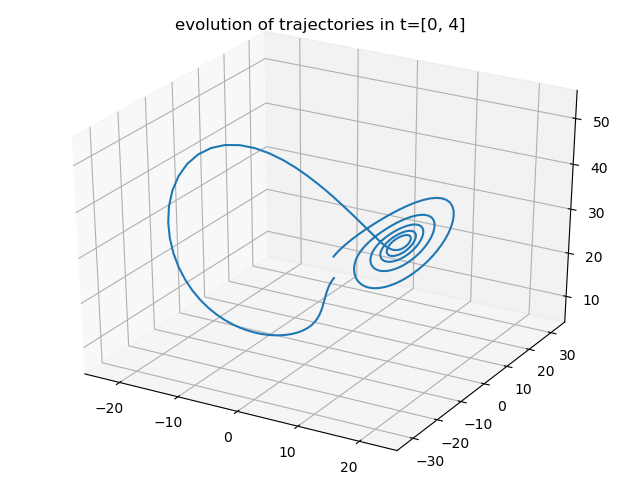

TypeError: object of type 'numpy.float64' has no len()

In [63]:
angle= -20
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
# ax.axis('off')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
ax.set_title('evolution of trajectories in t=[0, 4]')


lines_ref = ax.plot(x_obs, y_obs, z_obs, '-')
lines_inac = ax.plot(ret.x[0],ret.x[1],ret.x[2], '-') # CHANGE TO NUMPY ARRAY
plt.setp(lines_ref, linewidth=2,label='reference')
plt.setp(lines_inac, linewidth=2,label='inacurrate')
ax.view_init(30, angle)
plt.show()
plt.legend()

f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x_obs, label='x reference')
axarr[0].plot(ret.x[0], label='x inacurrate')
axarr[0].legend(loc="upper right")
axarr[1].plot(y_obs, label='y reference')
axarr[1].plot(ret.x[1], label='y inacurrate')
axarr[1].legend(loc="upper right")
axarr[2].plot(z_obs, label='z reference')
axarr[2].plot(ret.x[2], label='z inacurrate')
axarr[2].legend(loc="upper right")

In [36]:
v = np.zeros(3)
j_b = (v-u_b).T.dot(P_inv.dot((v-u_b)))
j = f(v)
j.shape
j_o = d[k].T.dot(R_inv.dot(d[k]))
y[k]

([2.069334254989946], [-2.0704096019082177], [26.82716441558183])

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
u[0].shape

In [ ]:
f(u_0)


## 3.4 additional questions

### Sensitivity of the solutions
For both extended and ensemble Kalman filter, look at :
- the sensitivity of the solution to the errors in the background
- the sensitivity of the solution to the model error Q. What is the impact of excluding the model error correlations ? What is the impact of increasing the magnitude of model error variances ?

Just for the Ensemble Kalman filter, what is the effect of changing :
- the size of the ensemble ?
- the size of the observation perturbation ?

### Less observations
- What happens if observations are not available for every variable (x, y, z) but only for the first variable x? Perform some experiments and provide some figures to illustrate them.
- What happens if observations are not available at every time? Perform some experiments and provide some figures to illustrate them.
- What happens if observations are not exact but corrupted by some (random) measurement errors? Perform some experiments and provide some figures to illustrate them.


In [ ]:
# to be done